In [16]:
# !pip install umap-learn
# !pip install python-chess
# !pip install tensorflow
# !pip install tqdm


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
import chess
import chess.pgn
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder


In [17]:
data = pd.read_csv('data/games.csv')

grouped_eco_labels = {
    'A00': 'Polish (Sokolsky) opening',
    'A01': 'Nimzovich-Larsen attack',
    'A02-A03': "Bird's opening",
    'A04-A09': 'Reti opening',
    'A10-A39': 'English opening',
    'A40-A41': "Queen's pawn",
    'A42': 'Modern defence, Averbakh system',
    'A43-A44': 'Old Benoni defence',
    'A45-A46': "Queen's pawn game",
    'A47': "Queen's Indian defence",
    'A48-A49': "King's Indian, East Indian defence",
    'A50': "Queen's pawn game",
    'A51-A52': 'Budapest defence',
    'A53-A55': 'Old Indian defence',
    'A56': 'Benoni defence',
    'A57-A59': 'Benko gambit',
    'A60-A79': 'Benoni defence',
    'A80-A99': 'Dutch',
    'B00': "King's pawn opening",
    'B01': 'Scandinavian (centre counter) defence',
    'B02-B05': "Alekhine's defence",
    'B06': 'Robatsch (modern) defence',
    'B07-B09': 'Pirc defence',
    'B10-B19': 'Caro-Kann defence',
    'B20-B99': 'Sicilian defence',
    'C00-C19': 'French defence',
    'C20': "King's pawn game",
    'C21-C22': 'Centre game',
    'C23-C24': "Bishop's opening",
    'C25-C29': 'Vienna game',
    'C30-C39': "King's gambit",
    'C40': "King's knight opening",
    'C41': "Philidor's defence",
    'C42-C43': "Petrov's defence",
    'C44': "King's pawn game",
    'C45': "Scotch game",
    'C46': "Three knights game",
    'C47-C49': "Four knights, Scotch variation",
    'C50': "Italian Game",
    'C51-C52': "Evans gambit",
    'C53-C54': "Giuoco Piano",
    'C55-C59': "Two knights defence",
    'C60-C99': "Ruy Lopez (Spanish opening)",
    'D00': "Queen's pawn game",
    'D01': 'Richter-Veresov attack',
    'D02': "Queen's pawn game",
    'D03': 'Torre attack (Tartakower variation)',
    'D04-D05': "Queen's pawn game",
    'D06': "Queen's Gambit",
    'D07-D09': "Queen's Gambit Declined, Chigorin defence",
    'D10-D15': "Queen's Gambit Declined Slav defence",
    'D16': "Queen's Gambit Declined Slav accepted, Alapin variation",
    'D17-D19': "Queen's Gambit Declined Slav, Czech defence",
    'D20-D29': "Queen's gambit accepted",
    'D30-D42': "Queen's gambit declined",
    'D43-D49': "Queen's Gambit Declined semi-Slav",
    'D50-D69': "Queen's Gambit Declined",
    'D70-D79': 'Neo-Gruenfeld defence',
    'D80-D99': 'Gruenfeld defence',
    'E00': "Queen's pawn game",
    'E01-E09': 'Catalan, closed',
    'E10': "Queen's pawn game",
    'E11': 'Bogo-Indian defence',
    'E12-E19': "Queen's Indian defence",
    'E20-E59': 'Nimzo-Indian defence',
    'E60-E99': "King's Indian defence"
}


def map_eco_to_grouped_label(eco_code):
    for key, value in grouped_eco_labels.items():
        if '-' in key:
            start, end = key.split('-')
            if start <= eco_code <= end:
                return value
        elif eco_code == key:
            return value
    return 'Other'

data['grouped_opening'] = data['opening_eco'].apply(map_eco_to_grouped_label)

def count_illegal_moves(moves):
    board = chess.Board()
    illegal_count = 0
    for move in moves.split():
        try:
            board.push_san(move)
        except:
            illegal_count += 1
            break
    return illegal_count


data['illegal_moves'] = data['moves'].apply(count_illegal_moves)
illegal_moves_count = data['illegal_moves'].sum()
print(f"Total illegal moves detected: {illegal_moves_count}")

data = data[data['illegal_moves'] == 0]

grouped_opening_counts = data['grouped_opening'].value_counts()

valid_openings = grouped_opening_counts[grouped_opening_counts >= 10].index

filtered_data = data[data['grouped_opening'].isin(valid_openings)]

data = filtered_data

Total illegal moves detected: 0


In [18]:
tqdm.pandas()

In [19]:
def generate_5d_board_states(moves):
    board = chess.Board()
    piece_type_map = {'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
                      'p': 0, 'n': 1, 'b': 2, 'r': 3, 'q': 4, 'k': 5}
    board_states = []

    for move in moves.split():
        board.push_san(move)
        board_state = np.zeros((8, 8, 6, 2))
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                rank, file = chess.square_rank(square), chess.square_file(square)
                piece_type = piece_type_map[str(piece)]
                color = 1 if piece.color == chess.WHITE else 0
                board_state[rank, file, piece_type, color] = 1
        board_states.append(board_state)

    return board_states


In [20]:
def generate_4d_board_states(moves):
    board = chess.Board()
    piece_type_map = {'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
                      'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11}
    board_states = []

    for move in moves.split():
        board.push_san(move)
        board_state = np.zeros((8, 8, 12))
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                rank, file = chess.square_rank(square), chess.square_file(square)
                piece_type = piece_type_map[str(piece)]
                board_state[rank, file, piece_type] = 1
        board_states.append(board_state)

    return board_states

In [21]:
def generate_3d_board_states(moves):
    board = chess.Board()
    board_states = []

    for move in moves.split():
        board.push_san(move)
        board_state = np.zeros((32, 4))  
        piece_count = 0
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                rank, file = chess.square_rank(square), chess.square_file(square)
                color = 1 if piece.color == chess.WHITE else 0
                board_state[piece_count] = [rank, file, color, 1]  
                piece_count += 1
                if piece_count >= 32: 
                    break
        board_states.append(board_state)

    return board_states



In [22]:
def evaluate_representation(X_train, X_test, y_train, y_test, label):
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'{label} Representation:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1-Score: {f1:.4f}\n')


In [23]:
N_samples = 5000

In [24]:
data_subset = data.iloc[:N_samples].copy()

In [13]:
# data_subset['board_states_5d'] = data_subset['moves'].progress_apply(generate_5d_board_states)


100%|██████████| 5000/5000 [00:45<00:00, 108.82it/s]


In [25]:
def flatten_board_states(board_states_column):
    return np.array([state.flatten() for game in data_subset[board_states_column] for state in game])

In [15]:
# X_5d = flatten_board_states('board_states_5d')

In [26]:
y = np.repeat(data_subset['grouped_opening'], data_subset['moves'].apply(lambda x: len(x.split())))

In [17]:
# X_train_5d, X_test_5d, y_train, y_test = train_test_split(X_5d, y, test_size=0.2, random_state=42)

In [18]:
# evaluate_representation(X_train_5d, X_test_5d, y_train, y_test, '5D')

5D Representation:
Accuracy: 0.9551
F1-Score: 0.9550



In [27]:
data_subset['board_states_4d'] = data_subset['moves'].progress_apply(generate_4d_board_states)


100%|██████████| 5000/5000 [01:03<00:00, 79.00it/s]


In [28]:
X_4d = flatten_board_states('board_states_4d')

In [29]:
X_train_4d, X_test_4d, y_train, y_test  = train_test_split(X_4d, y, test_size=0.2, random_state=42)

In [15]:
# evaluate_representation(X_train_4d, X_test_4d, y_train, y_test, '4D')

4D Representation:
Accuracy: 0.9548
F1-Score: 0.9548



In [12]:
# data_subset['board_states_3d'] = data_subset['moves'].progress_apply(generate_3d_board_states)

100%|██████████| 5000/5000 [00:36<00:00, 135.97it/s]


In [13]:
# X_3d = flatten_board_states('board_states_3d')

In [14]:
# X_train_3d, X_test_3d, y_train, y_test = train_test_split(X_3d, y, test_size=0.2, random_state=42)

In [15]:
# evaluate_representation(X_train_3d, X_test_3d, y_train, y_test, '3D')

3D Representation:
Accuracy: 0.7949
F1-Score: 0.7960



In [34]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

pca = PCA(n_components=4)
X_4d_pca = pca.fit_transform(X_4d)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

Explained variance ratio by each component: [0.17638296 0.04426476 0.02828636 0.02193378]
Cumulative explained variance: [0.17638296 0.22064772 0.24893408 0.27086786]


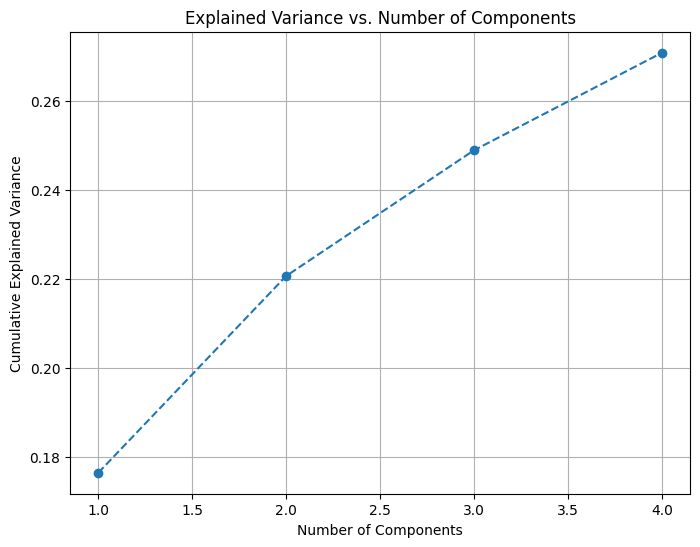

In [35]:
print(f'Explained variance ratio by each component: {explained_variance_ratio}')
print(f'Cumulative explained variance: {cumulative_explained_variance}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()